In [7]:
import tkinter as tk
from tkinter import ttk, messagebox
from bs4 import BeautifulSoup, Tag
import json
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import unittest
from unittest.mock import MagicMock, patch, Mock
import clipboard
from io import BytesIO
from PIL import Image, ImageTk


In [4]:
class NewsApp:
    def __init__(self):
        self.titles = []
        self.authors = []
        self.urls = []
        self.key = 'a9b66d7dfdb044679642c40bc7a1cff8'
        self.category_list = ['business','entertainment','general','health','science','technology','']
        self.country_list =['ae','ar','at','au','be','bg','br','ca','ch','cn','co','cu','cz','de','eg','fr','gb','gr','hk','hu','id','ie','il','in','it','jp','kr','lt','lv','ma','mx','my','ng','nl','no','nz','ph','pl','pt','ro','rs','ru','sa','se','sg','si',
         'sk','th','tr','tw','ua','us','ve','za','']

        # Create the main window
        self.root = tk.Tk()
        self.root.geometry('1000x800') 
        self.root.title("Information Aggregator")
        
        # Create labels using grid
        self.label = tk.Label(self.root, text="News Articles Searcher")
        self.label.grid(row=0, column=0, columnspan=2, padx=10, pady=10)

        self.country_label = tk.Label(self.root, text="Country:")
        self.country_label.grid(row=1, column=0, padx=5, pady=10)
        self.country_entry = tk.Entry(self.root)
        self.country_entry.grid(row=1, column=1, padx=10, pady=10)

        self.category_label = tk.Label(self.root, text="Category: \n1.Business\n2.Entertainment\n3.General\n4.Health\n5.Science\n6.Technology")
        self.category_label.grid(row=2, column=0, padx=5, pady=10)
        self.category_entry = tk.Entry(self.root)
        self.category_entry.grid(row=2, column=1, padx=10, pady=10)

        self.keyword_label = tk.Label(self.root, text="Keyword:")
        self.keyword_label.grid(row=1, column=2, padx=5, pady=10)
        self.keyword_entry = tk.Entry(self.root)
        self.keyword_entry.grid(row=1, column=3, padx=10, pady=10)

        self.totalResults_label = tk.Label(self.root, text="Number of Result:")
        self.totalResults_label.grid(row=2, column=2, padx=5, pady=10)
        self.showtotalResults_label = tk.Label(self.root, text="")
        self.showtotalResults_label.grid(row=2, column=3, padx=10, pady=10)

        # Create a Search button
        self.search_button = tk.Button(self.root, text="Search", command=self.fetch_news)
        self.search_button.grid(row=6, column=1, padx=10, pady=10)   

        self.result_label = tk.Label(self.root, text="")
        self.result_label.grid(row=3, column=1, padx=10, pady=10)
        
        # Create a select button
        self.select_button = tk.Button(self.root, text="Select", command=self.select_news)
        self.select_button.grid(row=6, column=2, padx=10, pady=10)

        # Create an image button
        self.image_button = tk.Button(self.root, text="Category Distribution", command=self.image)
        self.image_button.grid(row=6, column=3, padx=10, pady=10)

        # Create a Treeview for displaying data in a table
        self.tree = ttk.Treeview(self.root, columns=('No','Title', 'Author','Publish_Date'), show='headings')
        self.tree.heading('No', text='No', anchor=tk.CENTER)
        self.tree.column('No', minwidth=50, width=50)
        
        self.tree.heading('Title', text='Title', anchor=tk.CENTER)
        self.tree.column('Title', minwidth=400, width=500) 
       
        self.tree.heading('Author', text='Author', anchor=tk.CENTER)
        self.tree.column('Author', minwidth=100, width=200)    

        self.tree.heading('Publish_Date', text='Publish_Date', anchor=tk.CENTER)
        self.tree.column('Publish_Date', minwidth=100, width=200)           
        
        self.tree.grid(row=7, column=0, columnspan=8, padx=10, pady=10, sticky='nsew')
        
        # Create a vertical scrollbar
        self.scrollbar_y = tk.Scrollbar(self.root, orient='vertical', command=self.tree.yview)
        self.scrollbar_y.grid(row=7, column=8, sticky='ns')
        self.tree.configure(yscrollcommand=self.scrollbar_y.set)

        # Run the main loop
        self.root.mainloop()

    def fetch_news(self):
        country = self.country_entry.get()
        category = self.category_entry.get()
        keyword = self.keyword_entry.get()

        if category.lower() not in self.category_list:
            tk.messagebox.showinfo("Invalid Category", "Please input a valid category.")
            return 
        elif country.lower() not in self.country_list:
            tk.messagebox.showinfo("Invalid Country", "Please input a valid country.")
            return 

        try:
            api_url = f'https://newsapi.org/v2/top-headlines?country={country}&category={category}&q={keyword}&pageSize=100&apiKey={self.key}'
            response = requests.get(api_url)
            if response.status_code == 200:
                data = response.json()
                articles = data.get("articles", [])
                
                self.titles = [article["title"] for article in articles]
                self.authors = [article["author"] for article in articles]
                self.no = [i+1 for i in range(len(self.titles))]
                self.Publish_Date = [article["publishedAt"] for article in articles]
                self.urls = [article["url"] for article in articles]
                self.urlToImage = [article["urlToImage"] for article in articles] 
                self.formatted_dates = []
                
                for date in self.Publish_Date:
                    formatted_date = date[:10]
                    self.formatted_dates.append(formatted_date)   

                self.contents = [article["content"] for article in articles]
                self.update_table()
            else:
                tk.messagebox.showinfo("Error!", "Error fetching data. Please try again later.")
        except Exception as e:
            tk.messagebox.showinfo("Error!", f"An error occurred: {str(e)}")


    def update_table(self):
        # Clear existing items in the tree
        self.tree.delete(*self.tree.get_children())
        
        # Insert new data into the tree
        for no, title, author, pulish_date in zip(self.no, self.titles, self.authors, self.formatted_dates):
            self.tree.insert('', 'end', values=(no, title, author, pulish_date))

        self.showtotalResults_label.config(text= len(self.titles))
    
    def select_news(self):
        # Get the selected item from the Treeview
        selected_items = self.tree.selection()
        if not selected_items:
            tk.messagebox.showinfo("Selection", "Select a News for detail.")
            return
        
        for selected_items in self.tree.selection():
            selected_content = self.tree.item(selected_items)
            index = selected_content['values'][0]
            # Extract details of the selected news
            title = self.titles[index-1]
            author = self.authors[index-1]
            url = self.urls[index-1]
            content = self.contents[index-1]
            urlToImage = self.urlToImage[index-1]
            self.scrape_website(url,content, urlToImage)          
            
            # Copy URL to clipboard
            clipboard.copy(url)
            

    def image(self):
        country = self.country_entry.get()
        keyword = self.keyword_entry.get()
        category_list = ['business','entertainment','general','health','science','technology']
        num_result = {}
        for i in category_list:
            api_url = f'https://newsapi.org/v2/top-headlines?country={country}&category={i}&q={keyword}&pageSize=100&apiKey={self.key}'
            try:
                response = requests.get(api_url)
                if response.status_code == 200:
                    data = response.json()
                    resultno = data["totalResults"]
                    num_result[i] = resultno 
                else:
                    tk.messagebox.showinfo("Error!", "Error fetching data. Please try again later.")
            except Exception as e:
                tk.messagebox.showinfo("Error!", f"An error occurred: {str(e)}")

        image_window = tk.Toplevel(self.root)
        image_window.geometry("700x700")
        if country == '' and keyword == '':
            image_window.title(f"Bar Chart of Category distribution of all country")
        elif country == '':
            image_window.title(f"Bar Chart of Category distribution of all country with keyword '{keyword}'")
        elif keyword == '':
            image_window.title(f"Bar Chart of Category distribution of country '{country}'")
        else:
            image_window.title(f"Bar Chart of Category distribution of country '{country}' with keyword '{keyword}'")
            
        # Create the bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(num_result.keys(), num_result.values(),color=(0.2,0.4,0.2,0.6))
        ax.set_xlabel('Categories')
        ax.set_ylabel('Number of Results')
        if country == '' and keyword == '':
            ax.set_title(f"Bar Chart of Category distribution of all country")
        elif country == '':
            ax.set_title(f"Bar Chart of Category distribution of all country with keyword '{keyword}'")
        elif keyword == '':
            ax.set_title(f"Bar Chart of Category distribution of country '{country}'")
        else:
            ax.set_title(f"Bar Chart of Category distribution of country '{country}' with keyword '{keyword}'")

        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

        # Create a FigureCanvasTkAgg object to display the chart in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=image_window)
        canvas.draw()
        canvas.get_tk_widget().pack()
    

    def scrape_website(self, url, content, urlToImage ):   
        try:
            response = requests.get(url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')

                
                content = soup.find_all(['p', 'div', 'article'])  # Find paragraphs, divs, and articles

                # Filter out irrelevant content
                relevant_content = []
                for tag in content:
                    if 'class' in tag.attrs:
                        classes = tag.attrs['class']
                        relevant_classes = [
                            'story-body__', 'article-body', 'content', 'entry-content',
                            'article__body', 'post-content', 'content__body'
                        ]
                        if any(class_ in classes for class_ in relevant_classes) and len(tag.text.split()) > 30 and not tag.name.startswith('h') and tag.name != 'a':
                            relevant_content.append(tag)
                    elif tag.name == 'p' and len(tag.text.split()) > 30 and not tag.name.startswith('h') and tag.name != 'a':  # Only consider paragraphs with no classes
                        relevant_content.append(tag)

                if not relevant_content and content is not None:
                    # If no relevant content is found, find the first container with more than 30 words
                    for tag in soup.find_all():
                        if isinstance(tag, Tag) and len(tag.text.split()) > 30 and not tag.name.startswith('h') and tag.name != 'a':
                            relevant_content.append(tag)
                            break

                if not relevant_content:
                    messagebox.showinfo("Info", "No relevant content found on the page.")
                    self.root.clipboard_clear()
                    self.root.clipboard_append(url)
                    return

                # Extract text from relevant content
                scraped_content = "\n\n".join(tag.text.strip() for tag in relevant_content)

                content_window = tk.Toplevel(self.root)
                content_window.geometry("600x600")
                content_window.title(f"Content for: {url}")

                # Adding a Text widget with scrollbars and improved alignment
                text_frame = tk.Frame(content_window)
                text_scroll_y = tk.Scrollbar(text_frame, orient=tk.VERTICAL)
                text_scroll_x = tk.Scrollbar(text_frame, orient=tk.HORIZONTAL)
                content_text = tk.Text(
                    text_frame, wrap=tk.WORD,
                    yscrollcommand=text_scroll_y.set,
                    xscrollcommand=text_scroll_x.set,
                    padx=10, pady=10,  
                    spacing3=10  
                )

                text_scroll_y.config(command=content_text.yview)
                text_scroll_x.config(command=content_text.xview)

                text_frame.pack(fill=tk.BOTH, expand=True)
                text_scroll_y.pack(side=tk.RIGHT, fill=tk.Y)
                text_scroll_x.pack(side=tk.BOTTOM, fill=tk.X)
                content_text.pack(fill=tk.BOTH, expand=True)

                # Insert scraped content and set focus
                content_text.insert(tk.END, scraped_content)
                content_text.config(state=tk.DISABLED)  
                content_text.focus_set()

            elif content is None:
                self.root.clipboard_clear()
                self.root.clipboard_append(url)
                messagebox.showinfo(
                    "Error",
                    f"Failed to scrape content from {url}. Please check the link for details."
                )
                return

            else:
                scraped_content = content
                content_window = tk.Toplevel(self.root)
                content_window.geometry("600x600")
                content_window.title(f"Content for: {url}")

                # Adding a Text widget with scrollbars and improved alignment
                text_frame = tk.Frame(content_window)
                text_scroll_y = tk.Scrollbar(text_frame, orient=tk.VERTICAL)
                text_scroll_x = tk.Scrollbar(text_frame, orient=tk.HORIZONTAL)
                content_text = tk.Text(
                    text_frame, wrap=tk.WORD,
                    yscrollcommand=text_scroll_y.set,
                    xscrollcommand=text_scroll_x.set,
                    padx=10, pady=10, 
                    spacing3=10  
                )

                text_scroll_y.config(command=content_text.yview)
                text_scroll_x.config(command=content_text.xview)

                text_frame.pack(fill=tk.BOTH, expand=True)
                text_scroll_y.pack(side=tk.RIGHT, fill=tk.Y)
                text_scroll_x.pack(side=tk.BOTTOM, fill=tk.X)
                content_text.pack(fill=tk.BOTH, expand=True)

                # Insert scraped content and set focus
                content_text.insert(tk.END, scraped_content)
                content_text.config(state=tk.DISABLED)  
                content_text.focus_set()

            if urlToImage is not None:
                # Make the request to get the image
                response = requests.get(urlToImage, stream=True)

                # Check if the request was successful
                if response.status_code == 200:
                    # Check the content type to ensure it's an image
                    if 'image' in response.headers.get('content-type', ''):
                        try:
                            # Open the image from the response content
                            im = Image.open(BytesIO(response.content))
                            im.thumbnail((600, 600))
                            tk_image = ImageTk.PhotoImage(im)
                            content_text.image_create(tk.END, image=tk_image)
                            content_text.image = tk_image
                        except Exception as e:
                            content_text.insert(tk.END, f'Cant open the image: {e}')

        except Exception as e:
            self.root.clipboard_clear()
            self.root.clipboard_append(url)
            messagebox.showinfo("Error", f"An error occurred: {str(e)}\nFor more details, see the article: {url}")

        self.root.clipboard_clear()
        self.root.clipboard_append(url)

        
# Create an instance of the NewsApp class
app = NewsApp()

test_category_input (__main__.TestNewsApp) ... ok
test_country_input (__main__.TestNewsApp) ... ok
test_image_function (__main__.TestNewsApp) ... ok
test_scrape_website_failure (__main__.TestNewsApp) ... ok
test_scrape_website_no_relevant_content (__main__.TestNewsApp) ... ok
test_select_news (__main__.TestNewsApp) ... ok

----------------------------------------------------------------------
Ran 6 tests in 5.597s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

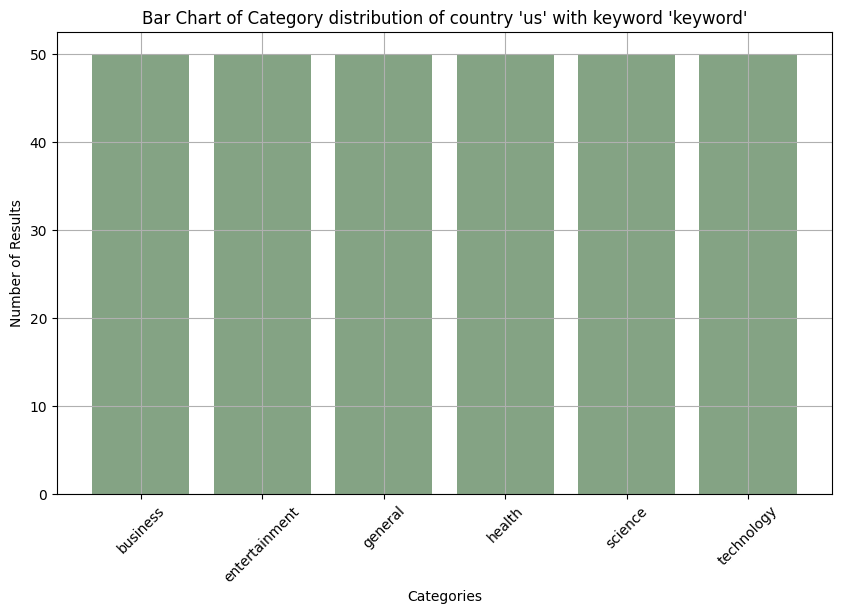

In [8]:
class TestNewsApp(unittest.TestCase):
    
    def setUp(self):
        with patch.object(tk.Tk, 'mainloop'), patch.object(tk.Tk, 'withdraw'):
            self.app = NewsApp()

    @patch('tkinter.messagebox.showinfo')
    def test_category_input(self, mock_showinfo):
        with patch.object(tk.Tk, 'mainloop'), patch.object(tk.Tk, 'withdraw'):
            # Mocking the entry widgets
            self.app.category_entry = MagicMock()
            self.app.country_entry = MagicMock()
            self.app.keyword_entry = MagicMock()

            # Setting return values with invalid category
            self.app.category_entry.get.return_value = 'invalid_category'
            self.app.country_entry.get.return_value = 'us'
            self.app.keyword_entry.get.return_value = 'keyword'
            self.app.fetch_news()

            # Verify that the correct message box is shown
            mock_showinfo.assert_called_with("Invalid Category", "Please input a valid category.")

            # Reset the mock to clear previous calls
            mock_showinfo.reset_mock()
            self.app.category_entry.get.return_value = 'general'
            self.app.fetch_news()

            # Verify that no message box is shown
            mock_showinfo.assert_not_called()

            # Reset the mock to clear previous calls
            mock_showinfo.reset_mock()
            self.app.category_entry.get.return_value = 'General'
            self.app.fetch_news()

            # Verify that no message box is shown
            mock_showinfo.assert_not_called()

            # Reset the mock to clear previous calls
            mock_showinfo.reset_mock()
            self.app.category_entry.get.return_value = 'GENERAL'
            self.app.fetch_news()

            # Verify that no message box is shown
            mock_showinfo.assert_not_called()

    @patch('tkinter.messagebox.showinfo')
    def test_country_input(self, mock_showinfo):
        with patch.object(tk.Tk, 'mainloop'), patch.object(tk.Tk, 'withdraw'):
            # Mocking the entry widgets
            self.app.category_entry = MagicMock()
            self.app.country_entry = MagicMock()
            self.app.keyword_entry = MagicMock()

            # Setting return values with invalid country and no other entry
            self.app.category_entry.get.return_value = ''
            self.app.country_entry.get.return_value = 'australia'
            self.app.keyword_entry.get.return_value = ''
            self.app.fetch_news()

            # Verify that the correct message box is shown
            mock_showinfo.assert_called_with("Invalid Country", "Please input a valid country.")

            # Setting return values with invalid country with other entry
            mock_showinfo.reset_mock()
            self.app.category_entry.get.return_value = 'general'
            self.app.country_entry.get.return_value = 'australia'
            self.app.keyword_entry.get.return_value = 'keyword'
            self.app.fetch_news()

            # Verify that the correct message box is shown
            mock_showinfo.assert_called_with("Invalid Country", "Please input a valid country.")

            # Setting return values with valid country
            mock_showinfo.reset_mock()
            self.app.category_entry.get.return_value = ''
            self.app.country_entry.get.return_value = 'au'
            self.app.keyword_entry.get.return_value = ''
            self.app.fetch_news()

            # Verify that no message box is shown
            mock_showinfo.assert_not_called()

            # Setting return values with valid country
            mock_showinfo.reset_mock()
            self.app.category_entry.get.return_value = 'general'
            self.app.country_entry.get.return_value = 'au'
            self.app.keyword_entry.get.return_value = 'keyword'
            self.app.fetch_news()

            # Verify that no message box is shown
            mock_showinfo.assert_not_called()

    @patch('tkinter.messagebox.showinfo')
    def test_select_news(self, mock_showinfo):
        with patch.object(tk.Tk, 'mainloop'), patch.object(tk.Tk, 'withdraw'):
            self.app.selected_items = MagicMock()
            self.app.selected_items.get.return_value = None
            self.app.select_news()
            mock_showinfo.assert_called_with("Selection", "Select a News for detail.")

    @patch('requests.get')
    @patch('tkinter.messagebox.showinfo')
    def test_image_function(self, mock_showinfo, mock_requests_get):
        with patch.object(tk.Tk, 'mainloop'), patch.object(tk.Tk, 'withdraw'):
            # Mocking the entry widgets
            self.app.category_entry = MagicMock()
            self.app.country_entry = MagicMock()
            self.app.keyword_entry = MagicMock()

            # Mocking the return values of the entry widgets
            self.app.category_entry.get.return_value = 'general'
            self.app.country_entry.get.return_value = 'us'
            self.app.keyword_entry.get.return_value = 'keyword'

            # Creating a fake response for the requests.get call
            fake_response = MagicMock()
            fake_response.status_code = 200
            fake_response.json.return_value = {
                "totalResults": 50,
                "articles": [
                    {"title": "Test Article", "author": "Author", "publishedAt": "2023-05-23T00:00:00Z", "url": "http://example.com", "content": "Test content"}
                ]
            }
            mock_requests_get.return_value = fake_response

            # Call the image method
            self.app.image()

            # Verify that the API was called with the expected URL for each category
            categories = ['business', 'entertainment', 'general', 'health', 'science', 'technology']
            for category in categories:
                expected_url = f'https://newsapi.org/v2/top-headlines?country=us&category={category}&q=keyword&pageSize=100&apiKey={self.app.key}'
                mock_requests_get.assert_any_call(expected_url)

            # Check if the bar chart is created correctly
            self.assertEqual(mock_requests_get.call_count, len(categories))
            mock_showinfo.assert_not_called()

            # Check if a new window for the bar chart is created
            self.assertGreater(len(self.app.root.winfo_children()), 0) # Adjust the number based on your specific widgets

    @patch('requests.get')
    def test_scrape_website_failure(self, mock_get):
        with patch.object(tk.Tk, 'mainloop'), patch.object(tk.Tk, 'withdraw'):
            mock_response = Mock()
            mock_response.status_code = 404
            mock_get.return_value = mock_response

            url = 'http://invalidurl.com'
            content = None
            urlToImage = None

            with patch('tkinter.messagebox.showinfo') as mock_messagebox:
                self.app.scrape_website(url, content, urlToImage)
                mock_messagebox.assert_called_with("Error", "Failed to scrape content from http://invalidurl.com. Please check the link for details.")
    @patch('requests.get')
    def test_scrape_website_no_relevant_content(self, mock_get):
        with patch.object(tk.Tk, 'mainloop'), patch.object(tk.Tk, 'withdraw'):
            mock_response = Mock()
            mock_response.status_code = 200
            mock_response.content = '<html><body><div>Short content.</div></body></html>'
            mock_get.return_value = mock_response

            url = 'http://example.com/test'
            content = None
            urlToImage = None

            with patch('tkinter.messagebox.showinfo') as mock_messagebox:
                # Preventing the pop-up from showing
                mock_messagebox.side_effect = lambda *args: self.app.root.quit()
                self.app.scrape_website(url, content, urlToImage)
                mock_messagebox.assert_called_with("Info", "No relevant content found on the page.")
                self.assertEqual(self.app.root.clipboard_get(), url)

    def tearDown(self):
        # Destroy the Tkinter root window after each test
        if hasattr(self, 'app'):
            self.app.root.destroy()
                



test_suite = unittest.TestLoader().loadTestsFromTestCase(TestNewsApp)
test_runner = unittest.TextTestRunner(verbosity=2)
test_runner.run(test_suite)
